In [1]:
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


print(tf.__version__)
print(np.__version__)

2.3.0
1.18.5


In [2]:
# divide uma série temporal univariada em amostras
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontra o final da amostra
        end_ix = i + n_steps
        # verifica se passou do final
        if end_ix > len(sequence)-1:
            break
        # junta as partes de entrada e saída do padrão
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
df = pd.read_csv('sp_beaches_update.csv', parse_dates=['Date'])
df = df.sort_values(by=['Date'])
df=df.loc[~df['Enterococcus'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74422 entries, 0 to 70886
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   City          74422 non-null  object        
 1   Beach         74422 non-null  object        
 2   Date          74422 non-null  datetime64[ns]
 3   Enterococcus  74422 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB


In [4]:
cidade="UBATUBA"
praia="GRANDE"
 
df_beach = df.loc[df['City']==cidade].loc[df['Beach']==praia][['Date','Enterococcus']]
df_beach.columns = ['ds', 'y']
df_beach.set_index('ds', inplace=True)
df_beach

,y
ds,
2012-01-03,5
2012-01-08,42
2012-01-15,92
2012-01-22,16
2012-01-29,9
...,...
2021-07-12,1
2021-07-19,38
2021-07-26,17


In [5]:
# escolhe o número de pontos no tempo que serão utilizados para treinar e prever o próximo ponto da série
n_steps = 16
# divide a série temporal, em amostras
X, y = split_sequence(df_beach.values, n_steps)
X.shape

(452, 16, 1)

In [6]:
y.shape

(452, 1)

In [7]:
# reshape de [samples, timesteps] para [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(452, 16, 1)

In [8]:
# definir o modelo
model = Sequential()
model.add(LSTM(104, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(104, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [9]:
# treinar o modelo
with tf.device('/GPU:0'): 
    R = model.fit(X, y, epochs=200, verbose=1)
R

Epoch 1/200
15/15 [==============================] - 0s 15ms/step - loss: 782.7699
Epoch 2/200
15/15 [==============================] - 0s 13ms/step - loss: 735.0682
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 695.8829
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 684.2578
Epoch 5/200
15/15 [==============================] - 0s 13ms/step - loss: 669.1691
Epoch 6/200
15/15 [==============================] - 0s 14ms/step - loss: 659.9812
Epoch 7/200
15/15 [==============================] - 0s 13ms/step - loss: 652.4447
Epoch 8/200
15/15 [==============================] - 0s 13ms/step - loss: 632.2743
Epoch 9/200
15/15 [==============================] - 0s 13ms/step - loss: 637.7792
Epoch 10/200
15/15 [==============================] - 0s 13ms/step - loss: 637.7759
Epoch 11/200
15/15 [==============================] - 0s 13ms/step - loss: 690.1272
Epoch 12/200
15/15 [==============================] - 0s 13ms/step - loss: 633.3203
E

15/15 [==============================] - 0s 13ms/step - loss: 390.1278
Epoch 99/200
15/15 [==============================] - 0s 13ms/step - loss: 390.6938
Epoch 100/200
15/15 [==============================] - 0s 13ms/step - loss: 382.4832
Epoch 101/200
15/15 [==============================] - 0s 13ms/step - loss: 391.2401
Epoch 102/200
15/15 [==============================] - 0s 13ms/step - loss: 353.4025
Epoch 103/200
15/15 [==============================] - 0s 13ms/step - loss: 349.8541
Epoch 104/200
15/15 [==============================] - 0s 13ms/step - loss: 320.7253
Epoch 105/200
15/15 [==============================] - 0s 13ms/step - loss: 305.2086
Epoch 106/200
15/15 [==============================] - 0s 13ms/step - loss: 357.6052
Epoch 107/200
15/15 [==============================] - 0s 13ms/step - loss: 388.1506
Epoch 108/200
15/15 [==============================] - 0s 13ms/step - loss: 433.5825
Epoch 109/200
15/15 [==============================] - 0s 13ms/step - loss: 348.

15/15 [==============================] - 0s 13ms/step - loss: 198.1011
Epoch 195/200
15/15 [==============================] - 0s 13ms/step - loss: 202.2482
Epoch 196/200
15/15 [==============================] - 0s 13ms/step - loss: 216.1649
Epoch 197/200
15/15 [==============================] - 0s 13ms/step - loss: 125.9471
Epoch 198/200
15/15 [==============================] - 0s 13ms/step - loss: 104.7321
Epoch 199/200
15/15 [==============================] - 0s 13ms/step - loss: 75.7802
Epoch 200/200
15/15 [==============================] - 0s 13ms/step - loss: 68.2310


In [10]:
round(R.history['loss'][-1])

68

In [11]:
yhat = model.predict(X, verbose=1)
print(y.shape)
print(yhat.shape)

15/15 [==============================] - 0s 5ms/step
(452, 1)
(452, 1)


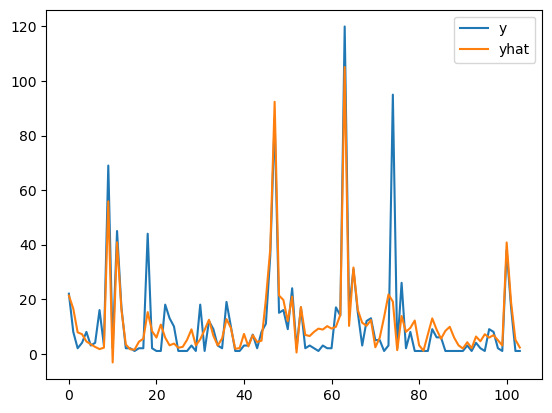

In [12]:
ultimos = 104
pd.DataFrame({'y':y[-ultimos:].reshape((ultimos)),'yhat':yhat[-ultimos:].reshape((ultimos))}).plot()
plt.show()

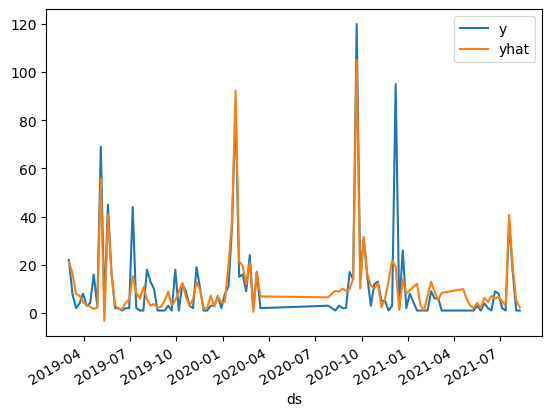

In [13]:
s1 = pd.DataFrame({'yhat':yhat.reshape((y.shape[0]))}, index=df_beach.index[-y.shape[0]:])
result = pd.concat([df_beach.iloc[-y.shape[0]:], s1], axis=1)
result.iloc[-104:].plot()
plt.show()